In [6]:
from PIL import Image 
path2content = 'tiger.jpg'
path2style = 'picture.jpg'

content_img = Image.open(path2content)
style_img = Image.open(path2style)


In [12]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)
])

content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


### transformation이 적용된 image 시각화

In [13]:
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

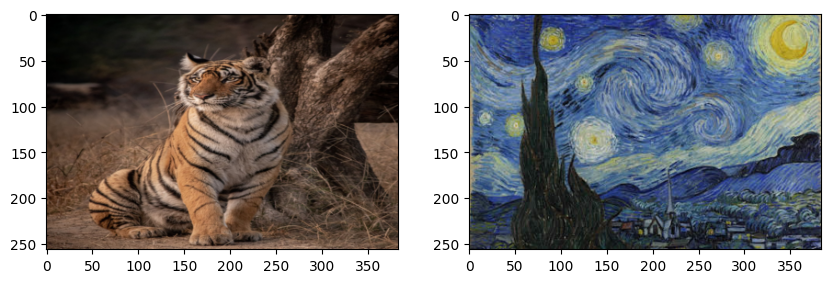

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))

### Style Transfer 구현

VGG19모델로 바꾸려하는 image와 변환하고자 하는 image의 특징 추출

In [23]:
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in model_vgg.parameters():
    param.requires_grad_(False)

c:\Users\com\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\com\anaconda3\envs\notebook\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### loss function 정의

In [18]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

gram matrix 는 style loss를 계산할 때 필요.

style loss는 input tensor와 style image의 gram matrix가 동일한 값을 갖는 방향으로 학습을 진행

In [19]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x,x.t())
    return gram

content loss는 content feature와 input feature 사이의 MSE를 계산

In [20]:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

style loss는 input과 gram matrix가 동일해지도록 학습

In [21]:
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

바꾸려하는 image와 적용시키려는 style image의 feature 추출

In [24]:
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [25]:
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


### optimizer 정의

In [26]:
input_tensor = con_tensor.clone().requires_grad_(True)

from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

In [27]:
num_epochs = 300
content_weight = 1e1
style_weight = 1e4
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}
                     
                     
# style transfer
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) 
    content_loss = get_content_loss(input_features, content_features, content_layer) 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss: 8.9e+01
epoch 100, content loss: 3.7, style loss: 9.1
epoch 200, content loss: 3.8, style loss: 2.6
epoch 300, content loss: 3.9, style loss: 1.2


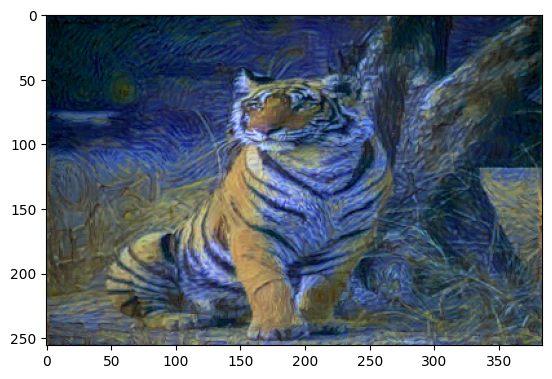

In [28]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))